<a href="https://colab.research.google.com/github/mpsenka21/vilds/blob/master/code/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial introduction to variational state-space models


In [ ]:
# Commands to clone needed repos and move files into home directory

In [ ]:
# main library
!git clone https://github.com/mpsenka21/vilds

Cloning into 'vilds'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 96 (delta 2), reused 9 (delta 1), pack-reused 80
Unpacking objects: 100% (96/96), done.


In [ ]:
# small mnist
!git clone https://github.com/mnielsen/rmnist

Cloning into 'rmnist'...
remote: Enumerating objects: 179, done.
remote: Total 179 (delta 0), reused 0 (delta 0), pack-reused 179
Receiving objects: 100% (179/179), 56.32 MiB | 8.32 MiB/s, done.
Resolving deltas: 100% (90/90), done.


In [ ]:
!mv vilds/code/GenerativeModel.py ./

In [ ]:
!mv vilds/code/lib/* ./

In [ ]:
!mv vilds/code/RecognitionModel.py ./

In [ ]:
!mv vilds/code/SGVB.py ./

In [ ]:
!mv rmnist/* ./

In [ ]:
# generate small mnist
!python data_loader.py

In [ ]:
# needed special version of lasagne for code to run
!pip install --upgrade https://github.com/Lasagne/Lasagne/archive/master.zip

     - 460kB 5.7MB/s
  Created wheel for Lasagne: filename=Lasagne-0.2.dev1-cp27-none-any.whl size=122797 sha256=877ce4dfa4e9f60e6a892f859f31f69e094c85a11f24037f6c239bafc57ac02d
  Stored in directory: /tmp/pip-ephem-wheel-cache-5jgfmc/wheels/ca/4a/00/87f1777b229481fe76562df7c0cfb993bc88ed0cc37e3f0ed4
Successfully built Lasagne


In [ ]:
# load Python/Theano stuff
%load_ext autoreload 
# Show figures inline with the code
%matplotlib inline   

import lasagne       # the library we're using for NN's
import theano
import theano.tensor as T
import theano.tensor.nlinalg as Tla
# import the nonlinearities we might use 
from lasagne.nonlinearities import leaky_rectify, softmax, linear, tanh, rectify, sigmoid
from theano.tensor.shared_randomstreams import RandomStreams
import numpy as np
from numpy.random import *
from matplotlib import pyplot as plt

import cPickle
import sys

# I always initialize random variables here. 
msrng = RandomStreams(seed=20150503)
mnrng = np.random.RandomState(20150503)

In [ ]:
theano.config.optimizer = 'fast_compile'

# Load our code

# Add all the paths that should matter right now
sys.path.append('lib')  # support files (mathematical tools, mostly)

from GenerativeModel import *       # Class file for generative models. 
from RecognitionModel import *      # Class file for recognition models
from SGVB import *                  # The meat of the algorithm - define the ELBO and initialize Gen/Rec model

# Generative models and sampling

The GenerativeModel.py file contains an abstract Generative model class, and implementations of a few example generative models: LDS (Kalman filter model), PLDS (LDS with Poisson count observations). The abstract GenerativeModel class describes all the functions you must implement to define a new GenerativeModel: methods for sampling from the model and and evaluating its log likelihood.


When initializing a new GenerativeModel instance, you define all its parameters in a dictionary. For the LDS and PLDS classes, most parameters have random initializations that will be used if they are not specified in the dictionary. 


In [ ]:
# Let's define a PLDS GenerativeModel. First, choose dimensionality of latent space and output:

xDim = 5
yDim = 28

# Generate random dynamics matrix A

A = np.random.randn(xDim, xDim)
u, s, vt = np.linalg.svd(A)
s_max = np.max(s)
S = np.diag(s) * (1/s_max)

A_scaled = np.dot(np.dot(u, S), vt)
####### Set up genertive model dictionary #######

# Define a neural network that maps the latent state into the output
gen_nn = lasagne.layers.InputLayer((None, xDim))
gen_nn = lasagne.layers.DenseLayer(gen_nn, yDim, nonlinearity=linear, W=lasagne.init.Orthogonal())
NN_XtoY_Params = dict([('network', gen_nn)])

# #Put all the parameters in a dictionary
gendict = dict([('A'     , 0.8*np.eye(xDim)),         # Linear dynamics parameters
                ('QChol' , 0.5*np.diag(np.ones(xDim))), # innovation noise
                ('Q0Chol', 0.5*np.diag(np.ones(xDim))), 
                ('x0'    , np.zeros(xDim)), 
#                ('RChol', np.ones(yDim)),             # observation covariance
                ('NN_XtoY_Params',NN_XtoY_Params),    # neural network output mapping
                ('output_nlin' , 'softplus')  # for poisson observations
                ])

# Instantiate a PLDS generative model:
true_model = PLDS(gendict, xDim, yDim, srng = msrng, nrng = mnrng)

# Now, we can sample from it:
Tt = 10000 # How many samples do we want?
[x_data, y_data] = true_model.sampleXY(Tt) # sample from the generative model  
print(y_data.shape)
# y_data = np.ones((Tt, yDim))
# and plot them
plt.figure()
# plt.subplot(121)
# plt.plot(x_data[:250,:2])
# plt.title('latent states')
# plt.subplot(122)
# plt.plot(y_data[:250,:2])
# plt.title('observations')

# true_model.evaluateLogDensity(x_data[:100], y_data[:100]).eval()


(2800, 28)


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
# extract small mnist
import gzip
import pickle


with gzip.open('data/rmnist_10.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f)

In [ ]:
# use MNIST as data
# NOTE: this is very ill-posed for a number of reasons
y_data = 100*np.ones((28*100, 28))

for i in range(100):
  y_data[28*i:28*(i+1),:] = train_set[0][i].reshape((28, 28))

xDim = 5
yDim = 28

# Recognition Model ("approximate posterior")


Our goal is to learn the parameters of $p_\theta(y|x)$ and the posterior $p(x|y)$. 

Since the posterior is hard to compute for most generative models, we approximate it using a Gaussian. Because we're interested in timeseries, we've designed our approximation to be able to express temporal correlations in a computationally fast way. In the code, we call this the "SmoothingTimeSeries" and "SmoothingLDSTimeSeries" recognition models (corresponding to the two parameterizations in Sec. 4 of the paper). 


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Text(0.5,1,'samples from an untrained approximate posterior')

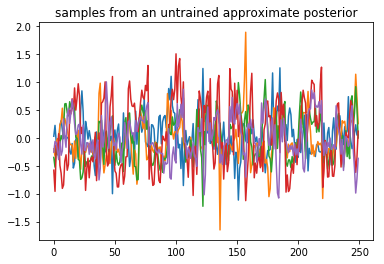

In [ ]:
########################################
# Describe network for mapping into means
NN_Mu = lasagne.layers.InputLayer((None, yDim))
NN_Mu = lasagne.layers.DenseLayer(NN_Mu, 25, nonlinearity=tanh, W=lasagne.init.Orthogonal())
#--------------------------------------
# let's initialize the first layer to have 0 mean wrt our training data
W0 = np.asarray(NN_Mu.W.get_value(), dtype=theano.config.floatX)
NN_Mu.W.set_value( (W0 / np.dot(y_data, W0).std(axis=0)).astype(theano.config.floatX) )
W0 = np.asarray(NN_Mu.W.get_value(), dtype=theano.config.floatX)
b0 = (-np.dot(y_data, W0).mean(axis=0)).astype(theano.config.floatX)
NN_Mu.b.set_value(b0)
#--------------------------------------
NN_Mu = lasagne.layers.DenseLayer(NN_Mu, xDim, nonlinearity=linear, W=lasagne.init.Normal())
NN_Mu.W.set_value(NN_Mu.W.get_value()*10)
NN_Mu = dict([('network', NN_Mu)])

########################################
# Describe network for mapping into Covariances
NN_Lambda = lasagne.layers.InputLayer((None, yDim))
NN_Lambda = lasagne.layers.DenseLayer(NN_Lambda, 25, nonlinearity=tanh, W=lasagne.init.Orthogonal())
#--------------------------------------
# let's initialize the first layer to have 0 mean wrt our training data
W0 = np.asarray(NN_Lambda.W.get_value(), dtype=theano.config.floatX)
NN_Lambda.W.set_value( (W0 / np.dot(y_data, W0).std(axis=0)).astype(theano.config.floatX) )
W0 = np.asarray(NN_Lambda.W.get_value(), dtype=theano.config.floatX)
b0 = (-np.dot(y_data, W0).mean(axis=0)).astype(theano.config.floatX)
NN_Lambda.b.set_value(b0)
#--------------------------------------
NN_Lambda = lasagne.layers.DenseLayer(NN_Lambda, xDim*xDim, nonlinearity=linear, W=lasagne.init.Orthogonal())
NN_Lambda.W.set_value(NN_Lambda.W.get_value()*10)
NN_Lambda = dict([('network', NN_Lambda)])

########################################
# define dictionary of recognition model parameters
recdict = dict([('A'     , .9*np.eye(xDim)),
                ('QinvChol',  np.eye(xDim)), #np.linalg.cholesky(np.linalg.inv(np.array(tQ)))),
                ('Q0invChol', np.eye(xDim)), #np.linalg.cholesky(np.linalg.inv(np.array(tQ0)))),
                ('NN_Mu' ,NN_Mu),
                ('NN_Lambda',NN_Lambda),
                ])

########################################
# We can instantiate a recognition model alone and sample from it. 
# First, we have to define a Theano dummy variable for the input observations the posterior expects:
Y = T.matrix()

rec_model = SmoothingLDSTimeSeries(recdict, Y, xDim, yDim, srng = msrng, nrng = mnrng)
rsamp = rec_model.getSample()

# to look at a sample, we have to evaluate it at data:
plt.figure()
plt.plot(rsamp.eval({Y: y_data[:250]})) # here, the data are mapping into the parameters
plt.title('samples from an untrained approximate posterior')


We train the generative model and recognition model together using gradient descent. We wrapped the SGVB objective function in the SGVB class. To train a generative and recognition model on data, we instantiate an instance of SGVB, passing in the GenerativeModel and RecognitionModel we wish to use (along with parameter dictionaries). 

In [ ]:
# initialize training with a random generative model (that we haven't generated data from):
initGenDict = dict([
             ('output_nlin' , 'softplus')  
                 ])

# Instantiate an SGVB class:
sgvb = SGVB(initGenDict, PLDS, recdict, SmoothingLDSTimeSeries, xDim = xDim, yDim = yDim)

In [ ]:
########################################
# Define a helper class to help us iterate through the training data
class DatasetMiniBatchIndexIterator(object):
    """ Basic mini-batch iterator """
    def __init__(self, y, batch_size=100, randomize=False):
        self.y = y
        self.batch_size = batch_size
        self.randomize = randomize
        from sklearn.utils import check_random_state
        self.rng = np.random.RandomState(np.random.randint(12039210))

    def __iter__(self):
        n_samples = self.y.shape[0]
        #if n_samples == self.batch_size:
        #    yield [self.y, np.arange(n_samples)]
        if self.randomize:
            for _ in xrange(n_samples / self.batch_size):
                if self.batch_size > 1:
                    i = int(self.rng.rand(1) * ((n_samples-self.batch_size-1)))
                else:
                    i = int(math.floor(self.rng.rand(1) * n_samples))
                ii = np.arange(i, i + self.batch_size)
                yield [self.y[ii], ii]
        else:
            for i in xrange((n_samples + self.batch_size - 1)
                            / self.batch_size):
                ii = np.arange(i*self.batch_size,(i+1)*self.batch_size)
                yield [self.y[ii], ii]

In [ ]:
########################################
# Define a bare-bones thenao training function
batch_y = T.matrix('batch_y')

########################################
# choose learning rate and batch size
learning_rate = 1e-2
batch_size = 100

########################################
# use lasagne to get adam updates
updates = lasagne.updates.adam(-sgvb.cost(), sgvb.getParams(), learning_rate=learning_rate)

########################################
# Finally, compile the function that will actually take gradient steps. 
train_fn = theano.function(
         outputs=sgvb.cost(),
         inputs=[theano.In(batch_y)],
         updates=updates,
         givens={sgvb.Y: batch_y},
    )

In [ ]:
########################################
# set up an iterator over our training data
yiter = DatasetMiniBatchIndexIterator(y_data, batch_size=batch_size, randomize=True)

########################################
# Iterate over the training data for the specified number of epochs
n_epochs = 20
cost = []
for ie in np.arange(n_epochs):
    print('--> entering epoch %d' % ie)
    for y, _ in yiter:
        cost.append(train_fn(y))
#        print cost[-1]

--> entering epoch 0


/usr/local/lib/python2.7/dist-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


--> entering epoch 1
--> entering epoch 2
--> entering epoch 3
--> entering epoch 4
--> entering epoch 5
--> entering epoch 6
--> entering epoch 7
--> entering epoch 8
--> entering epoch 9
--> entering epoch 10
--> entering epoch 11
--> entering epoch 12
--> entering epoch 13
--> entering epoch 14
--> entering epoch 15
--> entering epoch 16
--> entering epoch 17
--> entering epoch 18
--> entering epoch 19


Text(0,0.5,'Evidence Lower Bound (ELBO)')

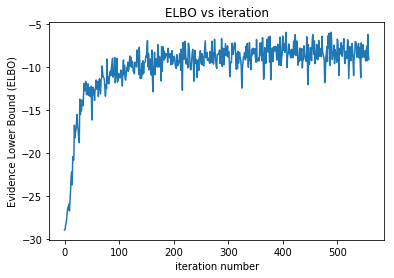

In [ ]:
########################################
# Iterate over the training data for the specified number of epochs
plt.plot(cost[1:])
plt.title('ELBO vs iteration')
plt.xlabel('iteration number')
plt.ylabel('Evidence Lower Bound (ELBO)')

We can access the trained generative and recognition models through the SGVB object, just as before.

In [ ]:
#########################
# Since the model is non-identifiable, let's find the best linear projection from the
# learned posterior mean into the 'true' training-data latents
pM = sgvb.mrec.postX.eval({sgvb.Y: y_data})
wgt = np.linalg.lstsq(pM-pM.mean(), x_data-x_data.mean())[0]   

NameError: ignored

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  if sys.path[0] == '':


Text(0.5,1,'samples from the trained approximate posterior')

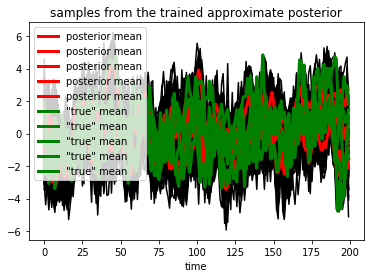

In [ ]:
######################### 
# Plot posterior means 
nT = 200 # number of timepoints to visualize
# Let's simulate some new test data from our original generative model 
[x_test, y_test] = true_model.sampleXY(nT)

#########################
# sample from the trained recognition model
rtrain_samp = sgvb.mrec.getSample()

plt.figure()
plt.hold('on')

#########################
# plot 25 samples from the posterior
for idx in np.arange(25): # plot multiple samples from the posterior
    xs = rtrain_samp.eval({sgvb.Y: y_test})
    plt.plot(np.dot(xs,wgt),'k')
# and now plot the posterior mean
pMtest = sgvb.mrec.postX.eval({sgvb.Y: y_test})
plt_post = plt.plot(np.dot(pMtest,wgt),'r', linewidth = 3, label = 'posterior mean')

plt_true = plt.plot(x_test, 'g', linewidth = 3, label = '\"true\" mean')

plt.legend(handles = plt_post + plt_true)
plt.xlabel('time')
plt.title('samples from the trained approximate posterior')


In [ ]:
y_test = 100*np.ones((28*100, 28))

for i in range(100):
  y_test[28*i:28*(i+1),:] = test_set[0][i].reshape((28, 28))
print(y_test)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
pMtrain = sgvb.mrec.postX.eval({sgvb.Y: y_data})
pMtest = sgvb.mrec.postX.eval({sgvb.Y: y_test})

In [ ]:
y_data_labels = np.zeros((100, 10))

for i in range(100):
  y_data_labels[i, train_set[1][i]] = 1

y_test_labels = np.zeros((100, 10))

for i in range(100):
  y_data_labels[i, test_set[1][i]] = 1

In [ ]:
# linear classifier on full data

x_train_lin = np.zeros((100, 28*28))
for i in range(100):
  x_train_lin[i, :] = train_set[0][i]
  
w = np.dot(np.dot(np.linalg.pinv(np.dot(x_train_lin.T, x_train_lin)), x_train_lin.T), y_data_labels)

# report test accuracy as percent
test_accuracy = 0.0

for i in range(100):
  test_img = test_set[0][i].reshape((1, 28*28))
  # evaluate linear classifier
  eval = np.dot(test_img, w)
  # see which classification is closest
  pred = np.argmax(eval)
  if pred == test_set[1][i]:
    test_accuracy += 1

test_accuracy = test_accuracy / 100
print('Test accuracy : ')
print(test_accuracy)

Test accuracy : 
0.41


In [ ]:
# linear classifier on latent dynamics

x_train_lin = np.zeros((100, 5*28))
for i in range(100):
  x_train_lin[i, :] = pMtrain[i*28:(i+1)*28,:].reshape(5*28)

w = np.dot(np.dot(np.linalg.pinv(np.dot(x_train_lin.T, x_train_lin)), x_train_lin.T), y_data_labels)

# report test accuracy as percent
test_accuracy = 0.0

for i in range(100):
  test_img = pMtest[i*28:(i+1)*28,:].reshape((1, 5*28))
  # evaluate linear classifier
  eval = np.dot(test_img, w)
  # see which classification is closest
  pred = np.argmax(eval)
  if pred == test_set[1][i]:
    test_accuracy += 1

test_accuracy = test_accuracy / 100
print('Test accuracy : ')
print(test_accuracy)

Test accuracy : 
0.28


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=3)
X = []
for i in range(100):
  X.append(train_set[0][i])

y = []
for i in range(100):
  y.append(train_set[1][i])

neigh.fit(X, y)

test_accuracy = 0.0
for i in range(100):
  test_img = train_set[0][i].reshape((1, 28*28))
  # see which classification is closest
  pred = neigh.predict(test_img)[0]
  if pred == train_set[1][i]:
    test_accuracy += 1

test_accuracy = test_accuracy / 100
print('Test accuracy : ')
print(test_accuracy)

Test accuracy : 
0.75


In [ ]:
neigh2 = KNeighborsClassifier(n_neighbors=3)
X2 = []
for i in range(100):
  X2.append(pMtrain[i*28:(i+1)*28,:].reshape(5*28))

y2 = []
for i in range(100):
  y2.append(train_set[1][i])

neigh2.fit(X2, y2)

# report test accuracy as percent
test_accuracy = 0.0
for i in range(100):
  test_img = pMtest[i*28:(i+1)*28,:].reshape((1, 5*28))
  # see which classification is closest
  pred = neigh2.predict(test_img)[0]
  if pred == test_set[1][i]:
    test_accuracy += 1

test_accuracy = test_accuracy / 100
print('Test accuracy : ')
print(test_accuracy)

Test accuracy : 
0.68


In [ ]:
cov_latent = np.cov(pMtrain.T)

In [ ]:
cov_latent.shape

(5, 5)

In [ ]:
cov_true = np.cov(y_data.T)

In [ ]:
cov_true.shape

(28, 28)

In [ ]:
u, s_latent, vt = np.linalg.svd(cov_latent)
u2, s_true, vt2 = np.linalg.svd(cov_true)
print(s_latent)
print(s_true)

print(np.sum(s_latent))
print(np.sum(s_true))

[1.03349088e+00 4.33181345e-01 1.78033166e-03 6.40548573e-04
 4.82075082e-04]
[7.98407845e-01 3.57744815e-01 3.18071574e-01 1.84859928e-01
 1.76435799e-01 1.08234268e-01 8.32138406e-02 5.05653218e-02
 4.25402677e-02 2.83823769e-02 2.11245704e-02 1.73486203e-02
 1.20593558e-02 1.02728114e-02 8.83088918e-03 7.57457785e-03
 6.12964425e-03 5.51044041e-03 4.67877139e-03 3.26693269e-03
 2.94124336e-03 1.38494297e-03 2.23417644e-04 1.73476469e-07
 5.73521679e-17 5.73521679e-17 5.73521679e-17 5.73521679e-17]
1.469575183024599
2.2498024279835347


In [ ]:
posterior_sample = sgvb.mprior.sampleXY(100*28)

In [ ]:
posterior_sample[1].shape

(2800, 28)

In [ ]:
generated_sequence = posterior_sample[1]

Text(0,0.5,'y')

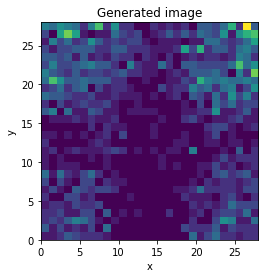

In [ ]:
index = 15
plt.figure()
plt.imshow(generated_sequence[index*28:(index+1)*28,:], origin='lower', interpolation='none', 
           extent=(0,28,0,28))
plt.title('Generated image')
plt.xlabel('x')
plt.ylabel('y')